<a href="https://colab.research.google.com/github/kleenman/tds_capstone/blob/pedro/munich_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas



In [3]:
import pandas as pd
import geopandas as gpd
from PIL import Image
from google.colab import drive
import requests
import json
import os
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
from PIL import Image

def rescale_image(filename, target_width=1000, target_height=1000):
    try:
        # Open the downloaded image using Pillow
        img = Image.open(filename)

        # Resize the image to the target dimensions while preserving the aspect ratio
        img.thumbnail((target_width, target_height))

        # Save the resized image
        img.save(filename)
        print(f"Image {filename} resized successfully!")
        return False
    except Exception as e:
        print(f"Error while resizing image {filename}: {e}")
        return True


In [ ]:
!pip install Pillow


In [5]:

# Load the GeoJSON file
gdf = gpd.read_file('https://raw.githubusercontent.com/kleenman/tds_capstone/main/bayernatlas_munich.geojson')

# Print the GeoDataFrame
gdf


,name,description,styleUrl,srid,geometry
0,München,<table>\n<tr><td>Gebiet:</td><td>München</td><...,"https://atlas.bayern.de/?c=677751,5422939&z=7&...",3857,"MULTIPOLYGON Z (((11.38870 48.19740 0.00000, 1..."


In [6]:
import re # for regex functions

In [7]:
munich_image_urls = pd.read_csv("https://raw.githubusercontent.com/kleenman/tds_capstone/main/munich.csv",header=None)
munich_image_urls.head()

,0
0,https://download1.bayernwolke.de/a/dop40/data/...
1,https://download1.bayernwolke.de/a/dop40/data/...
2,https://download1.bayernwolke.de/a/dop40/data/...
3,https://download1.bayernwolke.de/a/dop40/data/...
4,https://download1.bayernwolke.de/a/dop40/data/...


In [8]:
munich_image_urls[0]

0      https://download1.bayernwolke.de/a/dop40/data/...
1      https://download1.bayernwolke.de/a/dop40/data/...
2      https://download1.bayernwolke.de/a/dop40/data/...
3      https://download1.bayernwolke.de/a/dop40/data/...
4      https://download1.bayernwolke.de/a/dop40/data/...
                             ...                        
366    https://download1.bayernwolke.de/a/dop40/data/...
367    https://download1.bayernwolke.de/a/dop40/data/...
368    https://download1.bayernwolke.de/a/dop40/data/...
369    https://download1.bayernwolke.de/a/dop40/data/...
370    https://download1.bayernwolke.de/a/dop40/data/...
Name: 0, Length: 371, dtype: object

In [9]:
import requests
from io import BytesIO
def download_and_rescale_image(url,filename, target_width=1000, target_height=1000):
    try:

        response = requests.get(url)
        response.raise_for_status()

        # Open the downloaded image using Pillow
        img = Image.open(BytesIO(response.content))

        # Resize the image to the target dimensions while preserving the aspect ratio
        img.thumbnail((target_width, target_height))

        # Save the resized image
        img.save(filename)
        print("Image downloaded and resized successfully!")
        return False
    except Exception as e:
        print("Error",e)
        return True



# Read the CSV file to get the image URLs
munich_urls = munich_image_urls[0].tolist()
# Folder path in Google Drive where you want to save the images
save_folder_path = '/content/drive/MyDrive/Capstone/Data/munich_data'

# Loop through the image URLs and download/rescale each image
for url in munich_urls:
    filename = url.split('/')[-1]  # This gets the last part of the URL (e.g., '32700_5330.tif')
    filename_without_extension = filename.split('.')[0]  # Removes the file extension (e.g., '32700_5330')
    full_save_path = f"{save_folder_path}/{filename_without_extension}_resized.jpg"

    # Download and resize the image
    #download_and_rescale_image(url, full_save_path)

In [10]:
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 2.1 MB/s eta 0:00:00


In [11]:
import osmnx as ox
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from pyproj import Transformer
import os



In [38]:
transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326")
test = os.listdir('/content/drive/MyDrive/Capstone/Data/munich_data')[99]
parts = test.split('_')
parts
x = parts[0]
y = parts[1]
X = int(x[2:]) * 1000
Y = int(y) * 1000

X,Y

south, west = transformer.transform(X, Y)
north, east = transformer.transform(X + 1000, Y + 1000)
south, west, north, east
geo_information = ox.features_from_bbox(north, south, east, west, tags={'leisure': 'park'})


raster = np.zeros((1000,1000))
for x_west in range(1000):
            for y_north in range(1000):
                x_west_coordinate = X+x_west
                y_north_coordinate = (Y+1000)-y_north
                small_north,small_west = transformer.transform(x_west_coordinate,y_north_coordinate)
                small_south,small_east = transformer.transform(x_west_coordinate+1,y_north_coordinate-1)
                # create a polygon for each square metre
                square_metre = Polygon([(small_west,small_north),(small_east,small_north),(small_east,small_south),(small_west,small_south)])
                #compare it to the geoinformation and set the value to 1 if it intersects
                if geo_information.intersects(square_metre).any():
                    raster[y_north,x_west] = 1

raster
#if not geo_information.empty:
#  raster = np.zeros((1000,1000))
#  for feature in geo_information.itertuples():
#    for x_west in range(1000):
#      for y_north in range(1000):
#        x_coord = X+x_west
#        y_coord = Y+(1000-y_north)
#        point = transformer.transform(y_coord, x_coord)
#        if Polygon(feature.geometry).contains(point):
#          raster[999-y_north, x_west] = 1
#raster
#geo_information.plot()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

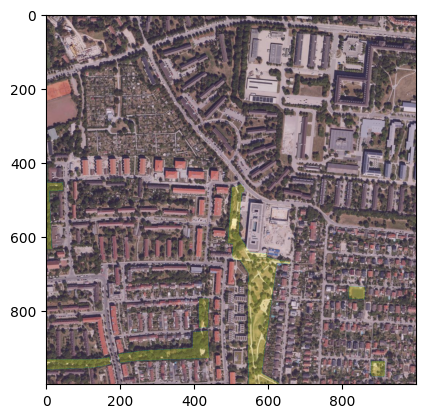

In [45]:
image = np.array(Image.open(f'/content/drive/MyDrive/Capstone/Data/munich_data/{test}'))
plt.imshow(image)
plt.imshow(raster, alpha=0.2);


In [41]:
def create_masks(name):
    base_dir = "/content/drive/MyDrive/Capstone/Data/munich_data"
    masks_dir = os.path.join(base_dir, "masks")
    os.makedirs(masks_dir, exist_ok=True)

    transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326")

    i = 0

    for f in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, f)):
            continue

        parts = f.split("_")
        X, Y = parts[0], parts[1]
        mask_filename = os.path.join(masks_dir, f"{int(X)/1000}_{int(Y)/1000}.npy")
        X = (int(X[2:]) if X.startswith("32") else int(X)) * 1000
        Y = int(Y) * 1000

        if os.path.exists(mask_filename):
            continue

        try:
            south, west = transformer.transform(Y, X)
            north, east = transformer.transform(Y + 1000, X + 1000)
            geo_information = ox.features_from_bbox(north, south, east, west, tags={'leisure': 'park'})

            if not geo_information.empty:
                raster = np.zeros((1000,1000))
                for x_west in range(1000):
                  for y_north in range(1000):
                    x_west_coordinate = X+x_west
                    y_north_coordinate = (Y+1000)-y_north
                    small_north,small_west = transformer.transform(x_west_coordinate,y_north_coordinate)
                    small_south,small_east = transformer.transform(x_west_coordinate+1,y_north_coordinate-1)
                    # create a polygon for each square metre
                    square_metre = Polygon([(small_west,small_north),(small_east,small_north),(small_east,small_south),(small_west,small_south)])
                    #compare it to the geoinformation and set the value to 1 if it intersects
                    if geo_information.intersects(square_metre).any():
                      raster[y_north,x_west] = 1
                      np.save(mask_filename, raster)
                i += 1
            else:
              np.save(mask_filename, np.zeros((1000, 1000)))
        except Exception as e:
          print(f"An error occurred for file {f}: {e}")
          np.save(mask_filename, np.zeros((1000, 1000)))
        if i >= 5:
          break

create_masks("munich")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


An error occurred for file 32700_5330_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occurred for file 32701_5331_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occurred for file 32697_5328_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occurred for file 32698_5328_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occurred for file 32698_5329_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occurred for file 32699_5328_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occurred for file 32696_5329_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occurred for file 32696_5331_resized.jpg: No data elements in server response. Check log and query location/tags.
An error occurre

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Capstone/Data/munich_data/masks/32.693_5.333.npy'

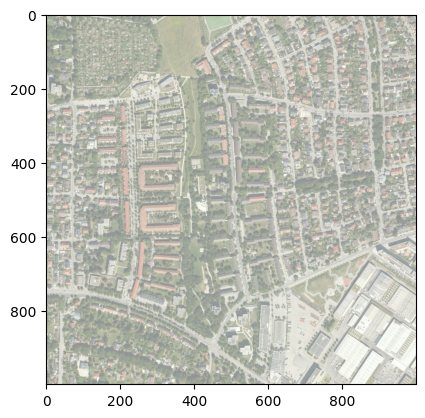

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
image = np.array(Image.open("/content/drive/MyDrive/Capstone/Data/munich_data/32685_5339_resized.jpg"))
mask = np.load("/content/drive/MyDrive/Capstone/Data/munich_data/masks/685-5339.npy")
plt.imshow(image)
plt.imshow(mask, cmap='Greens', alpha=0.5)  # Change color map to 'Greens'
plt.show()


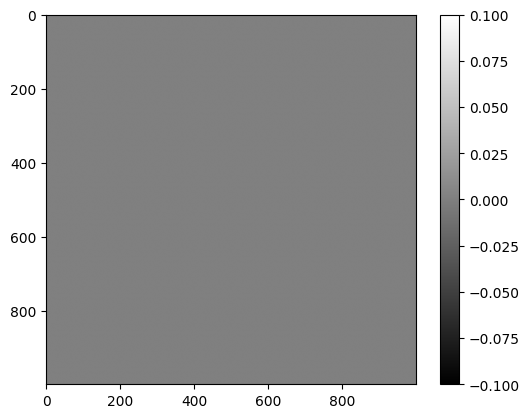

[0.]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the mask
mask = np.load("/content/drive/MyDrive/Capstone/Data/munich_data/masks/685-5339.npy")

# Display the mask
plt.imshow(mask, cmap='gray')  # Using 'gray' colormap to see the mask clearly
plt.colorbar()  # To show the scale of values in the mask
plt.show()
print(np.unique(mask))